In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
data = pd.read_csv('filtered_dataset.csv')

Arps approximation and MSLE calculation

In [27]:
labels = data.Conduit
X = data.drop('Conduit',axis=1)
n = len(X)

i = data.num
Y = X.values

indices = [i for i in range(len(Y[:]))]

def lin_app(k, b, x):
  return k*x+b

y_start_tmp = 0
k_arr, b_arr, q_start_arr, lbl_arr = [], [], [], []
x_new = np.arange(0, 24, 1)

#calculating Arps constants for each well
for i, lbl in zip(indices, labels):
  y_log = np.log(Y[i][1:25])

  if i > 0:
    if lbl != lbl_tmp:
      y_start = max(Y[i][1:3]) #selecting normalization q for each well
    else:
      y_start = y_start_tmp
  else:
    y_start = max(Y[0][1:3])

  y_start_tmp = y_start
  q_start_arr.append(y_start)
  lbl_tmp = lbl
  lbl_arr.append(lbl_tmp)

  k, b = np.polyfit(x_new, y_log - np.log(y_start), 1)
  k_arr.append(k)
  b_arr.append(b)

  #f = lin_app(k, b, x_new)

0.0002769622003001741 21.303976741778367
3834


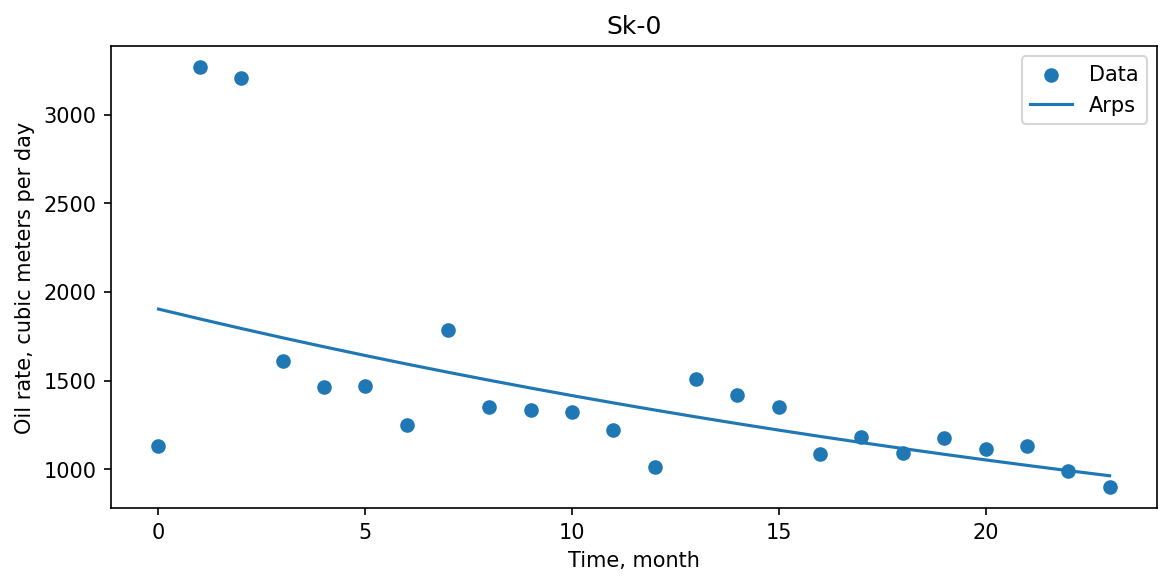

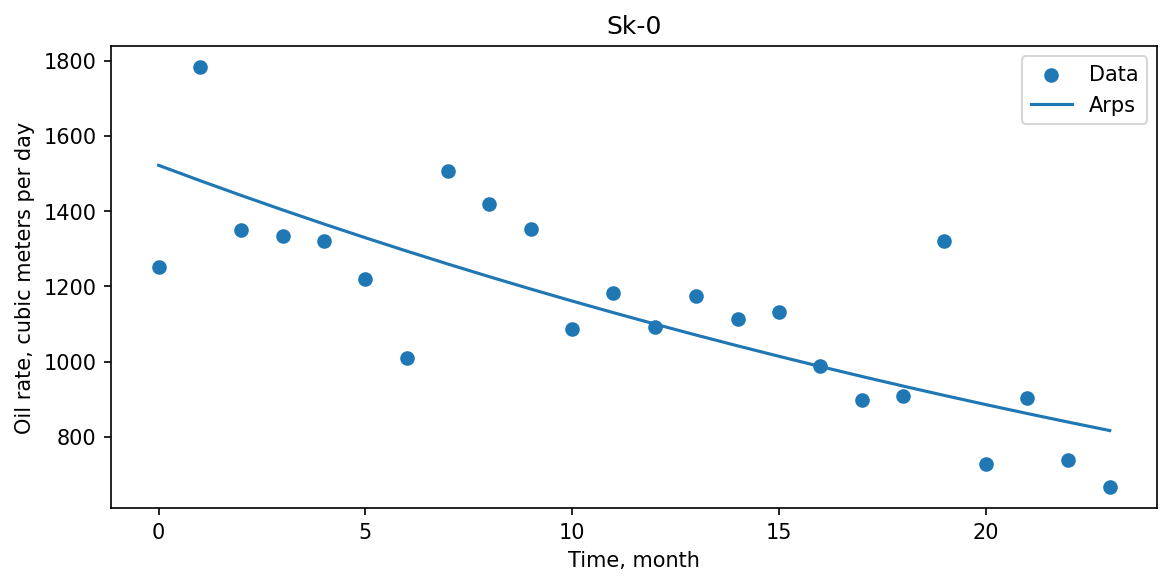

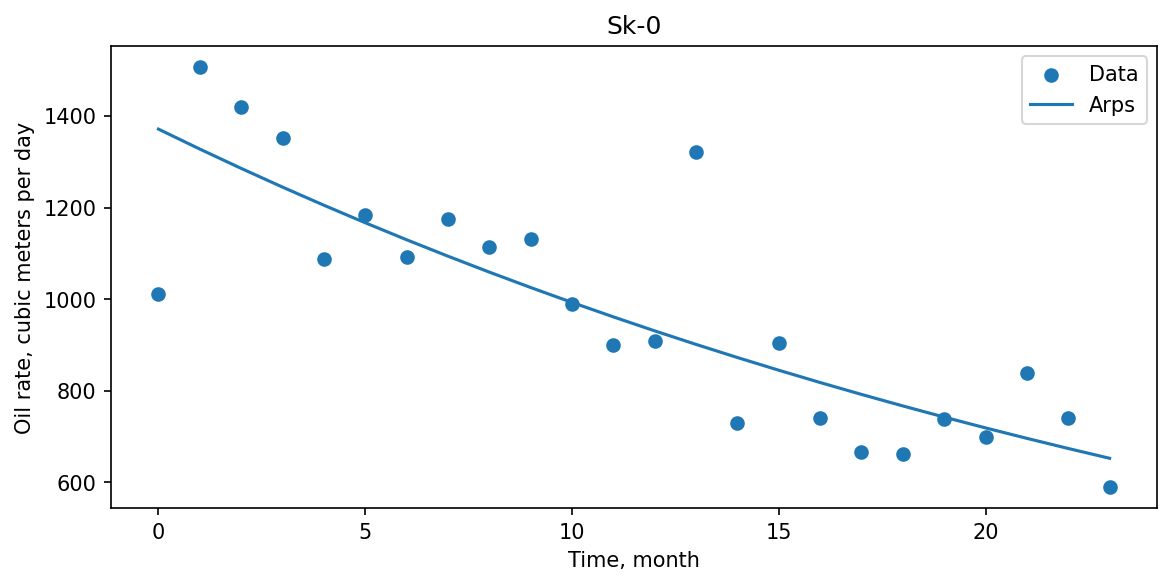

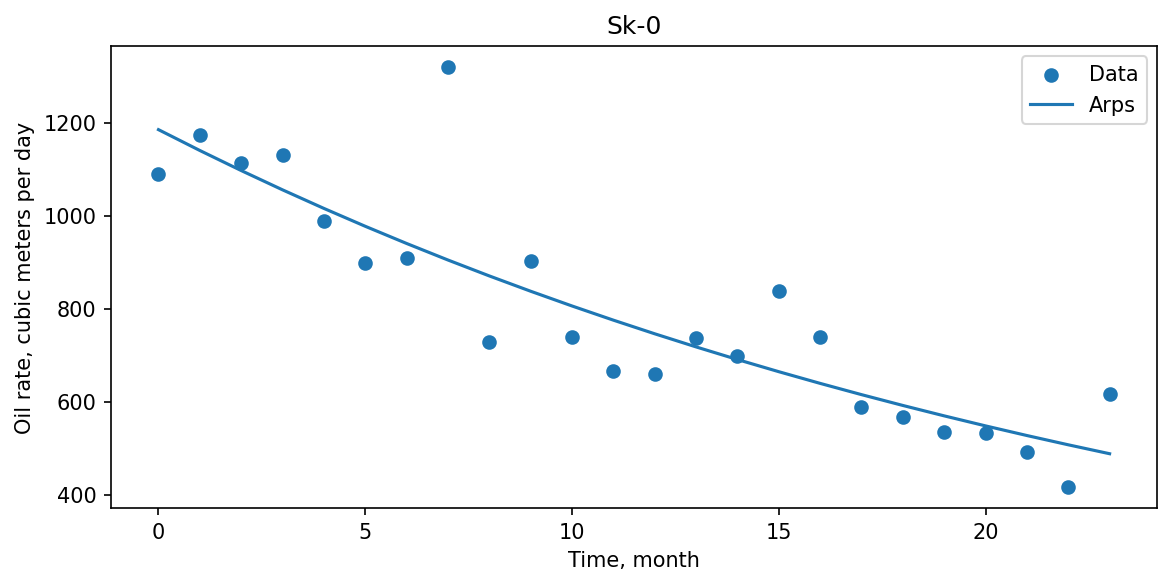

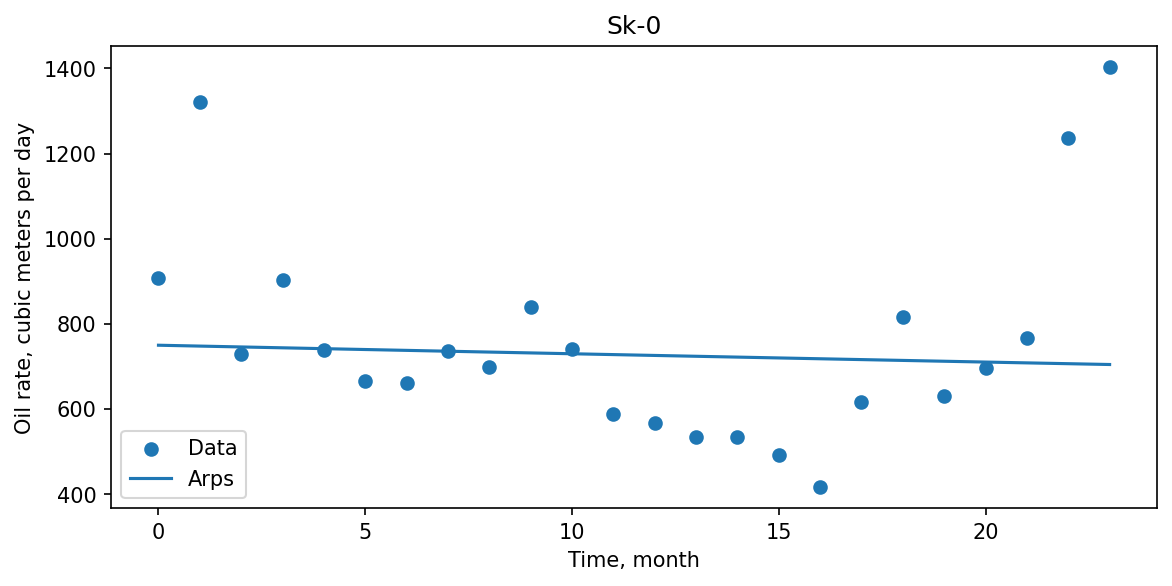

In [28]:
def Arps(q_start, k, b, x):
  return q_start*np.exp(k*x+b)

MSLE = []
x_pred = np.arange(24, 30, 1)
x_all = np.arange(0, 30, 1)

#print Arps approximations
for i, lbl in zip(indices, labels):
  f = []

  for x in x_all:
    f.append(Arps(q_start_arr[i], k_arr[i], b_arr[i], x))

  #calculating MSE
  MSLE_temp = 0
  for x in x_pred:
    MSLE_temp += pow(np.log(1 + f[x]) - np.log(1 + Y[i][x+1]), 2)

  MSLE.append(MSLE_temp/6)

  #print of some samples for visialization
  number = 5
  x_plt = np.arange(0, 24, 1)
  if i < number:
    plt.figure(figsize=(9, 4), dpi=150)
    plt.scatter(x_plt, Y[i][1:25])

    plt.plot(x_plt, f[:24], '-')
    plt.xlabel('Time, month')
    plt.ylabel('Oil rate, cubic meters per day')
    plt.title(lbl_arr[i])
    plt.legend(['Data','Arps'])

print(min(MSLE), max(MSLE))

print(len(MSLE))

After that, we aploaded the results of LSTM (see in corresponding notebook) and calculated MSLE for the test data

In [29]:
from sklearn.metrics import mean_squared_log_error

oil = pd.read_csv('filtered_dataset.csv')
pred = pd.read_csv('filtered_predictions.csv')
selected_columns_oil = oil.iloc[:, 25:31]
selected_columns_pred = pred.iloc[:, 1:7]
selected_columns_pred = selected_columns_pred.clip(lower=0)



In [30]:
msle = mean_squared_log_error(selected_columns_oil, selected_columns_pred)
msle_values = []

for n in range(3834):
    # Select row n from each DataFrame using iloc
    selected_row_oil = selected_columns_oil.iloc[n, :]
    selected_row_pred = selected_columns_pred.iloc[n, :]

    # Since mean_squared_log_error expects arrays, we convert rows to arrays
    # Calculate the Mean Squared Logarithmic Error for the two rows
    msle = mean_squared_log_error([selected_row_oil], [selected_row_pred])

    # Append the MSLE value to the list
    msle_values.append(msle)



In [31]:
import matplotlib.pyplot as plt
import plotly.express as px

Tried different approaches for visualization of results

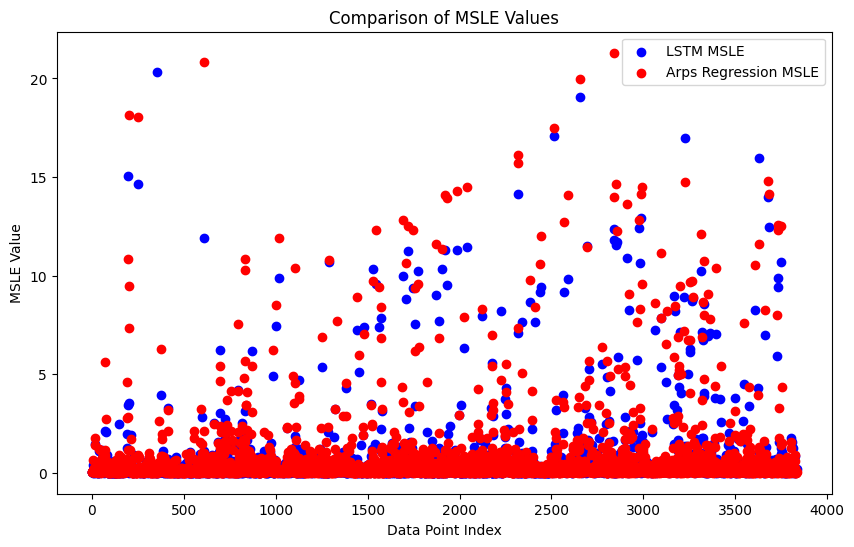

In [32]:
# Ensure 'indices' matches the length of your MSLE arrays
indices = list(range(1, len(msle_values) + 1))
indices_arps = list(range(1, len(MSLE) + 1))

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(indices, msle_values, color='blue', label='LSTM MSLE')
plt.scatter(indices_arps, MSLE, color='red', label='Arps Regression MSLE')

# Adding titles and labels
plt.title('Comparison of MSLE Values')
plt.xlabel('Data Point Index')
plt.ylabel('MSLE Value')
plt.legend()

# Show the plot
plt.show()

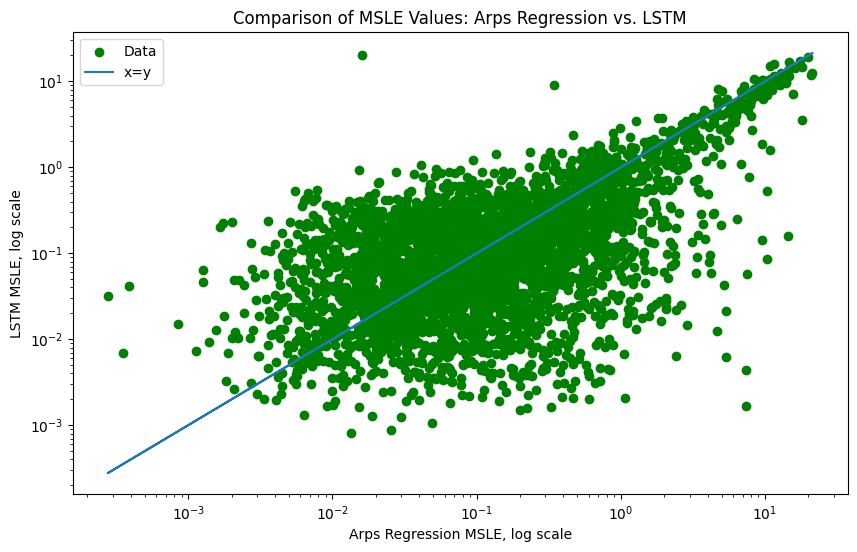

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(MSLE, msle_values, color='green')
plt.xscale('log')
plt.yscale('log')

# Adding titles and labels
plt.title('Comparison of MSLE Values: Arps Regression vs. LSTM')
plt.xlabel('Arps Regression MSLE, log scale')
plt.ylabel('LSTM MSLE, log scale')


plt.plot(MSLE, MSLE, '-')
plt.legend(['Data','x=y'])
# Show the plot
plt.show()

In [37]:
fig = px.scatter(x=MSLE, y=msle_values,
                 log_x = {'True'}, log_y = {'True'},
                 labels={'x': 'Arps Regression MSLE', 'y': 'LSTM MSLE'},
                 title='Comparison of MSLE Values: Arps Regression vs. LSTM')
fig.show()

In this subsection, we tried to interpret the results of clustering (clustering code is located in a corresponding notebook)

In [38]:
higher_msle_count = sum(MSLE > msle_values for MSLE, msle_values in zip(MSLE, msle_values))

higher_msle_count

2118

In [39]:
# Identify points where msle_values is lower than MSLE
lower_points_indices = [i for i, (msle_values, MSLE) in enumerate(zip(msle_values, MSLE)) if msle_values < MSLE]

# Prepare the data for the CSV file
data_to_save = {'Index': lower_points_indices, 'LSTM MSLE': [msle_values[i] for i in lower_points_indices], 'Arps MSLE': [MSLE[i] for i in lower_points_indices]}

# Convert to DataFrame
df_to_save = pd.DataFrame(data_to_save)

# Save to CSV
csv_file_path = 'D:\Work'
df_to_save.to_csv(csv_file_path, index=False)

csv_file_path

'D:\\Work'

In [42]:
def filter_and_save(msle_values, MSLE, close_to_zero_threshold, greater_than_value, file_suffix):
    """
    Filters points where msle_values is close to zero and MSLE is greater than a specified value.
    Saves the filtered points to a CSV file.
    """
    indices = [i for i, (msle, arps) in enumerate(zip(msle_values, MSLE))
               if msle <= close_to_zero_threshold and arps > greater_than_value]

    data_to_save = {
        'Index': indices,
        'LSTM MSLE': msle_values[indices],
        'Arps MSLE': MSLE[indices],
        'Sk label' : labels[indices]
    }

    # Convert to DataFrame
    df_to_save = pd.DataFrame(data_to_save)

    # Save to CSV
    csv_file_path = f'msle_points_{file_suffix}.csv'
    df_to_save["Index"].to_csv(csv_file_path, index=False)

    return df_to_save

# Define thresholds and values for filtering
close_to_zero_threshold = 0.5
greater_than_values = [2]

# Define MSLE values (example data)
MSLE_arps = np.array(MSLE)  # MSLE values with some close to zero
msle_values_lstm = np.array(msle_values)

# Filter and save to CSV files
file_paths = []
for value in greater_than_values:
    file_suffix = f'gt{value}'
    file_path = filter_and_save(msle_values_lstm, MSLE_arps, close_to_zero_threshold, value, file_suffix)
    file_paths.append(file_path)

file_paths

[      Index  LSTM MSLE  Arps MSLE Sk label
 199     199   0.140806   9.484131    Sk-26
 201     201   0.001676   7.329093    Sk-26
 363     363   0.025276   2.633620    Sk-47
 553     553   0.209373   2.095507    Sk-68
 697     697   0.094650   2.357641    Sk-97
 699     699   0.098658   2.082053    Sk-97
 734     734   0.006463   2.407009    Sk-99
 735     735   0.221346   3.708608    Sk-99
 754     754   0.051891   2.108213   Sk-100
 755     755   0.096576   4.122888   Sk-100
 795     795   0.057530   7.525021   Sk-102
 816     816   0.077099   2.357971   Sk-103
 836     836   0.164116   3.418018   Sk-104
 842     842   0.079676   4.109916   Sk-104
 869     869   0.134611   3.100167   Sk-106
 1095   1095   0.212703   4.921567   Sk-139
 1106   1106   0.085629  10.369065   Sk-140
 1108   1108   0.120658   2.316758   Sk-140
 1247   1247   0.333045   2.245860   Sk-166
 1382   1382   0.014756   2.898784   Sk-177
 1474   1474   0.073076   2.319188   Sk-206
 1573   1573   0.012368   4.6267

In [46]:
import plotly.graph_objs as go
import numpy as np

# Load the array
array = np.load('2 clusters.npy')

cluster = pd.read_csv('Cluster.csv')

cl_arr = cluster.drop('Conduit',axis=1)
cl_arr = cl_arr.values

Here I did the post-processing of clustering results.
The main idea was to print only last 6 month of oil rate clustering samples on a figure

In [49]:
cluster_zero, cluster_one = [], []
lbl_zero, lbl_one = [], []

indices_tmp = [i for i in range(len(Y[:]))]
for i in indices_tmp:
  if cl_arr[i] == [0]:
    cluster_zero.append(cl_arr[i])
    lbl_zero.append(labels[i])
  else:
    cluster_one.append(cl_arr[i])
    lbl_one.append(labels[i])


print(len(lbl_zero))
print(len(lbl_one))

print(lbl_zero)
print(lbl_one)

import csv

#np.save('lbl_zero.csv', lbl_zero)
#np.save('lbl_one.csv', lbl_one)

1628
2206
['Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-11', 'Sk-11', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-26', 'Sk-26', '

In [50]:
array1 = lbl_zero
array2 = lbl_one

from collections import Counter

# Create a set of unique values from array1
unique_values = set(array2)

# Count the occurrences of each value in array1
value_counts = Counter(array1)

# Create a new array with only the different values from array1 that are repeated more than once
new_array = []
for i, value in enumerate(array1):
    if value not in unique_values:
        if value_counts[value] > 2:
            new_array.append(value)
    else:
        unique_values.remove(value)

print(new_array)

print(len(new_array))

['Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-12', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-17', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-29', 'Sk-29', 'Sk-29', 'Sk-29', 'Sk-29', '

In [51]:
array1 = lbl_one
array2 = new_array

# Create a set of unique values from array1
unique_values = set(array2)

# Count the occurrences of each value in array1
value_counts = Counter(array1)

# Create a new array with only the different values from array1 that are repeated more than once
remaining_array = []
for i, value in enumerate(array1):
    if value not in unique_values:
      remaining_array.append(value)
    else:
      unique_values.remove(value)

print(remaining_array)

print(len(remaining_array))

['Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-0', 'Sk-4', 'Sk-4', 'Sk-4', 'Sk-4', 'Sk-4', 'Sk-9', 'Sk-9', 'Sk-9', 'Sk-9', 'Sk-9', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-10', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-11', 'Sk-12', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-13', 'Sk-17', 'Sk-17', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-19', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-22', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-23', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-24', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-26', 'Sk-29', 'Sk-29', 'Sk-31', 'Sk-31', 'Sk-31', 'Sk-31', 'Sk-31', 'Sk-31', 'Sk-31', 'Sk-31', 'Sk-34', 'Sk-34', 'Sk-34', 'Sk-36', 'Sk-36', 'Sk-36', 'Sk-36', 'Sk-36', 'Sk-36', 'Sk-36', 'Sk-36', 'Sk-36', 'Sk-36', 'Sk-37', 'Sk-37', 'Sk-37', 'Sk-37'

In [54]:
clus = pd.read_csv('Cl.csv')
# Removing duplicates, keeping the last occurrence
clus1 = clus.drop_duplicates(subset=['Conduit'], keep='last')

labels = clus1.Conduit
N = labels.values

Y = clus1.drop('Conduit',axis=1)
M = Y.values

Here I examined the possible interpetation of clustering that DBSCAN separated points based on somehow related type of well, water injection or oil well.

Spoiler: it's not how it is separated, but worth trying!

In [58]:
#oil = pd.read_csv('D:\Work\ML_project\Oil.csv')

import pandas as pd

# Read the Excel file
#df = pd.read_excel('WS_COORDS_SURF.xlsx')

# Write the DataFrame to a CSV file
#df.to_csv('WS_COORDS_SURF.csv', index=False)

ver = pd.read_csv('WS_COORDS_SURF.csv')
clas = ver[['Conduit', 'WellType']]
filtered = clas[clas['WellType'] == 'OIL SURF']
filtered1 = clus1[clus1['Conduit'].isin(filtered['Conduit'])]

In [60]:
lbls = filtered1.Conduit
Nn = lbls.values

Yy = filtered1.drop('Conduit',axis=1)
Mm = Yy.values


#for i in range(0,267,1):
#  if Mm[i] == [0]:
#    print(Nn[i])

In [61]:
#for i in range(0,267,1):
#  if Mm[i] == [1]:
#    print(Nn[i])